<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2005%20-%20Feature%20Extraction/Lecture_05_Feature_Extraction-Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA


In [14]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#The Character Dataset
First, we will create an Isolated Character Dataset to work with feature extraction

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


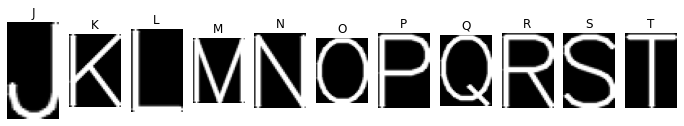

In [15]:
char_labels = []
char_dataset = []

#use a ascii codes to determine each char

#0 to 9
for n in range(48,58):
  char_labels.append(chr(n))

#A....Z
for n in range(65,91):
  char_labels.append(chr(n))

print(char_labels)

# font
font = cv2.FONT_HERSHEY_SIMPLEX
pt = (30, 80)
fontScale = 2
color = (255, 255, 255)
thickness = 2

#Create char images [0,1,2......w,x,z]
for C in char_labels:
  img = np.zeros((100,100),np.uint8)

  #Write the character C on the image
  img = cv2.putText(img, C, pt, font,
                    fontScale, color, thickness, cv2.LINE_AA)

  #Compute the bbox and crop
  a = np.where(img != 0)
  bbox = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])

  #ROI
  img = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
  char_dataset.append(img)

#Plotting some images
plot_sidebyside(char_dataset[19:30],char_labels[19:30],colormap='gray')


#Image Size as Feature

Considering the Character Dataset, one can argue that the image's height and width should be an interesting feature to determine its content (A, B...Z...0...9).

Below we shows that these features have no sufficient representation once several labels are mapped to the same region on the feature space. It is called a non-discriminative feature.

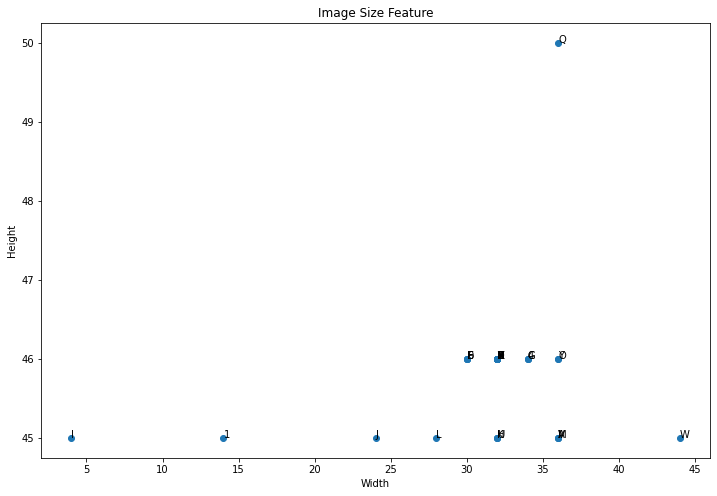

In [16]:

features = [(lambda x: x.shape)(x) for x in char_dataset]

y, x = zip(*features)

plt.figure(figsize=(12,8))
plt.scatter(x, y)
plt.title("Image Size Feature")
plt.xlabel("Width")
plt.ylabel("Height")

for i in range(len(x)):
  #print('[%d,%d,%s] ' % (x[i],y[i],chars[i]), end='')
  plt.text(x=x[i], y=y[i], s=char_labels[i])
plt.show()





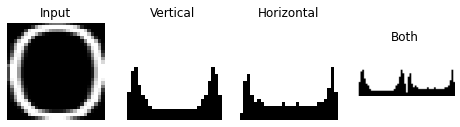

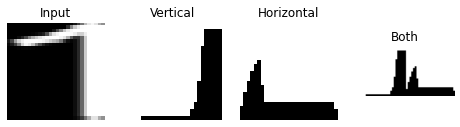

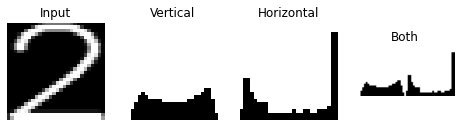

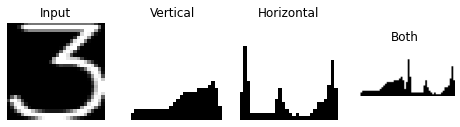

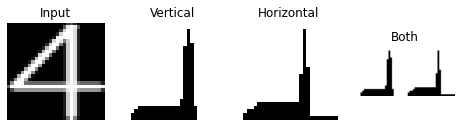

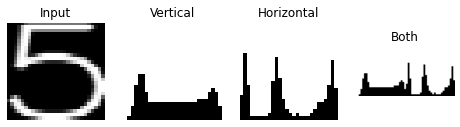

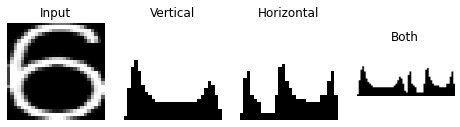

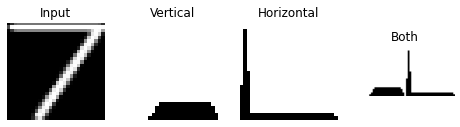

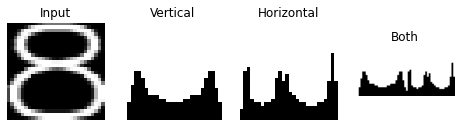

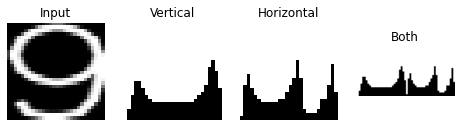

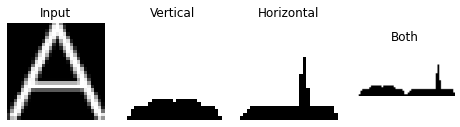

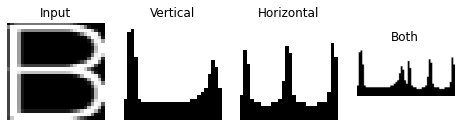

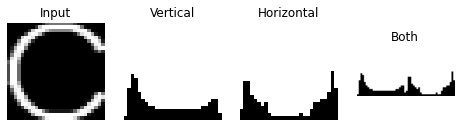

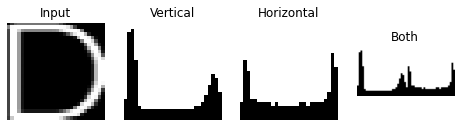

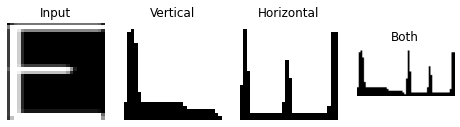

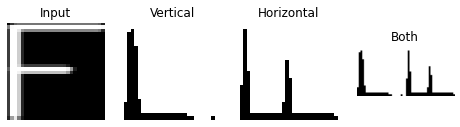

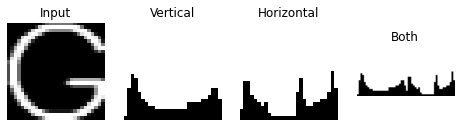

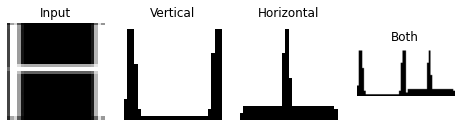

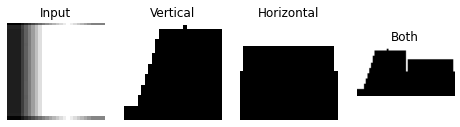

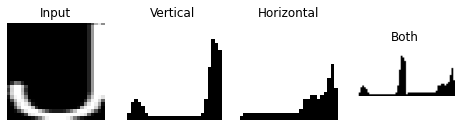

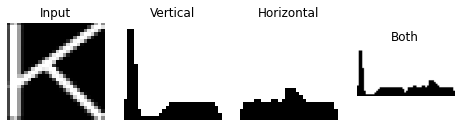

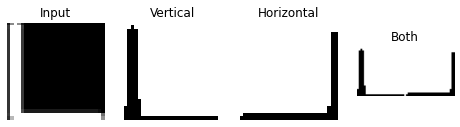

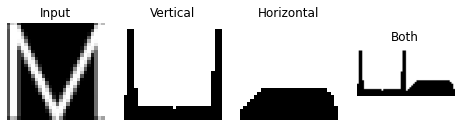

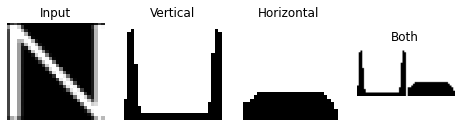

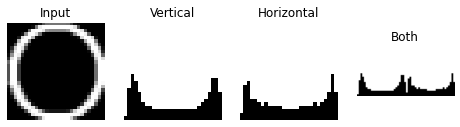

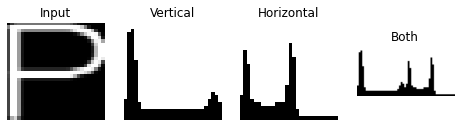

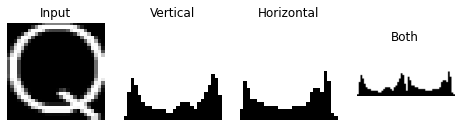

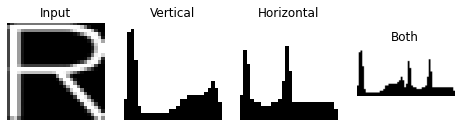

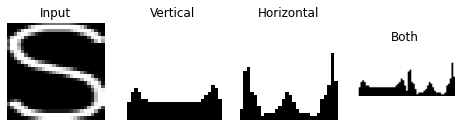

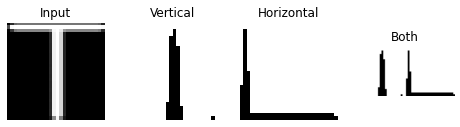

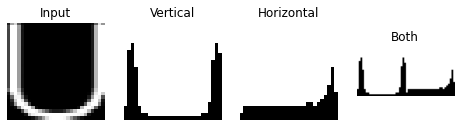

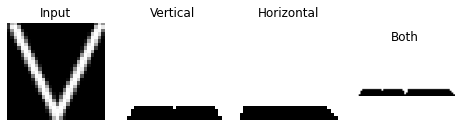

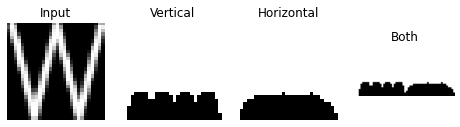

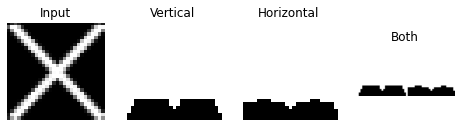

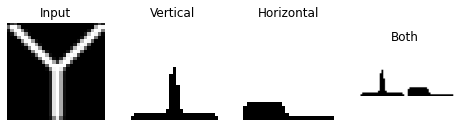

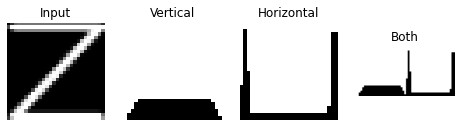

In [17]:
horiz_features = []
vert_features = []
hv_features = []

for img in char_dataset:

  #Normalization
  img = cv2.resize(img,(28,28))
  height, width = img.shape
 
  # Sum the value lines 
  vert = np.sum(img, axis=0)
  horiz = np.sum(img, axis=1)
  
  # Normalize 0-255
  vert = vert/255
  horiz = horiz/255
  both = np.concatenate([vert,horiz],axis = 0)
  
  horiz_features.append(vert)
  vert_features.append(horiz)
  hv_features.append(both)


  # create a black image with zeros 
  vert_proj = np.zeros((28,28),dtype=np.uint8)
  horiz_proj = np.zeros((28,28),dtype=np.uint8)
  both_proj = np.zeros((28,56),dtype=np.uint8)
  
  
  # Make the vertical projection histogram
  for idx, value in enumerate(vert):
      cv2.line(vert_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)

  for idx, value in enumerate(horiz):
      cv2.line(horiz_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)
  
  for idx, value in enumerate(both):      
      cv2.line(both_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)

  
  plot_sidebyside([img,vert_proj,horiz_proj,both_proj],['Input','Vertical','Horizontal','Both'],'gray',(8,8))

#Data Reduction and Visualization

Lets use the PCA to better understand the features and visualize them

In [18]:
def plot_features(pca_features,labels,title='PCA Plot',figsize=(12,8)):
  
  plt.figure(figsize=figsize)
  x, y = zip(*pca_features)
  plt.scatter(x, y)

  for i in range(len(x)):  
    plt.text(x=x[i], y=y[i], s=labels[i])
  
  plt.title(title)
  plt.show()

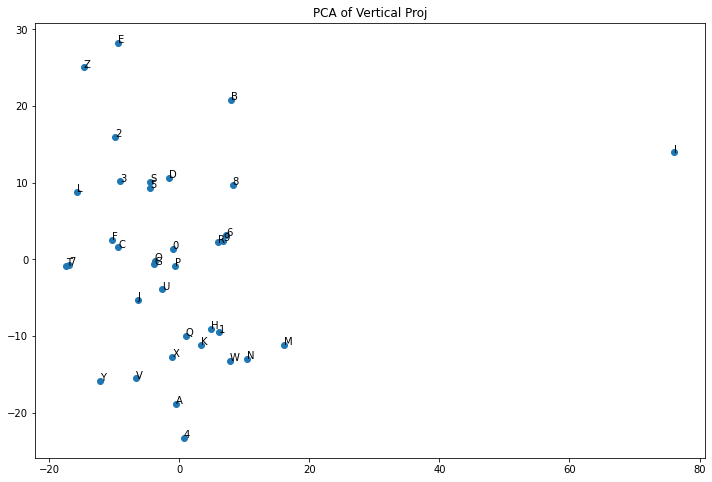

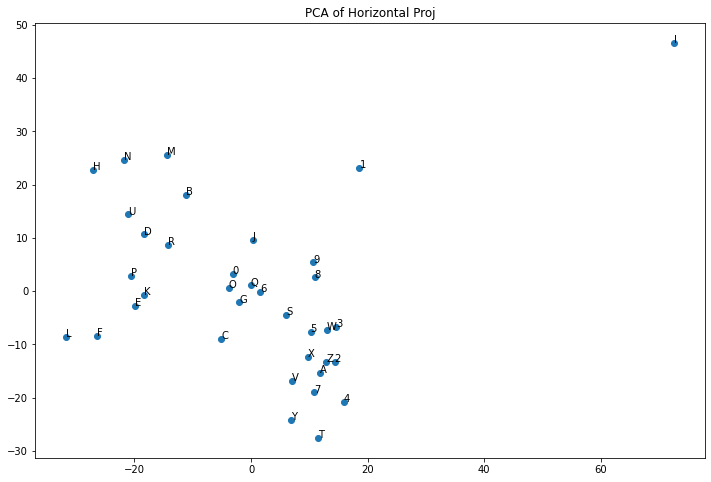

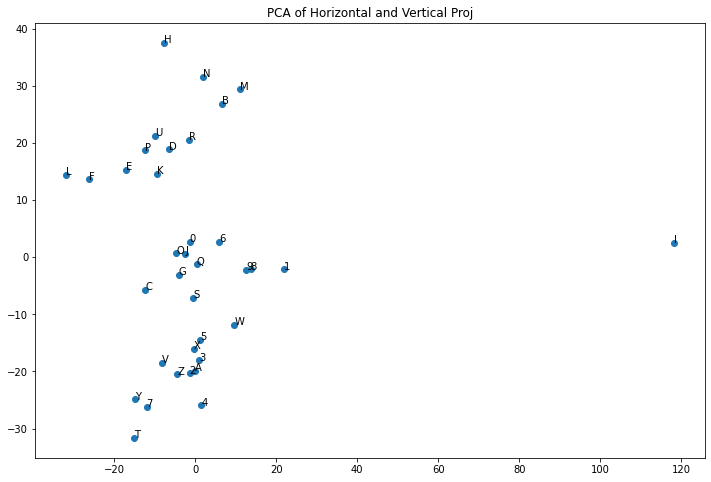

In [19]:
reduced_data = PCA(n_components=2).fit_transform(vert_features)
plot_features(reduced_data,char_labels,'PCA of Vertical Proj')

reduced_data = PCA(n_components=2).fit_transform(horiz_features)
plot_features(reduced_data,char_labels,'PCA of Horizontal Proj')

reduced_data = PCA(n_components=2).fit_transform(hv_features)
plot_features(reduced_data,char_labels,'PCA of Horizontal and Vertical Proj')



PCA Components Explanation

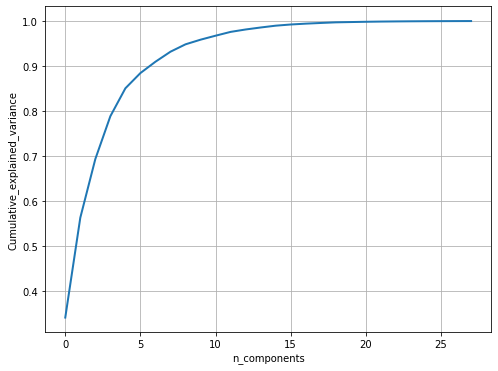

In [20]:
pca = PCA(n_components=28)
reduced_data = pca.fit_transform(hv_features)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)
                              
plt.figure(figsize=(8, 6))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

#The MNIST Dataset

*   Handwritten Digits
*   Challenges: Angle, Size, Noise, Broken...



11501568/11490434 [==============================] - 0s 0us/step
(28, 28)


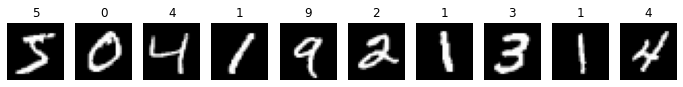

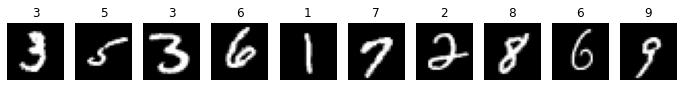

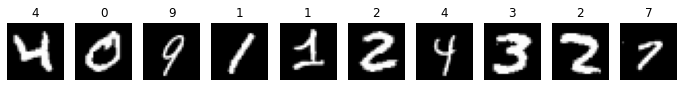

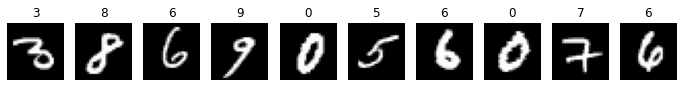

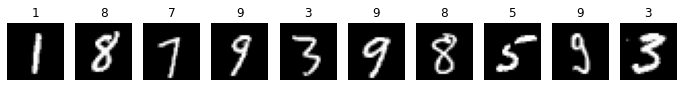

In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train[0].shape)
for i in range(0,5):
  idx = i*10

  plot_sidebyside(x_train[idx:idx+10],y_train[idx:idx+10],'gray')


#Pratice 01
  Produce the features learned until now and compute the feature space using PCA.

Now it's up to you!

Implement vertical and horizontal projection and evaluate the feature space!

(60000, 28, 28)


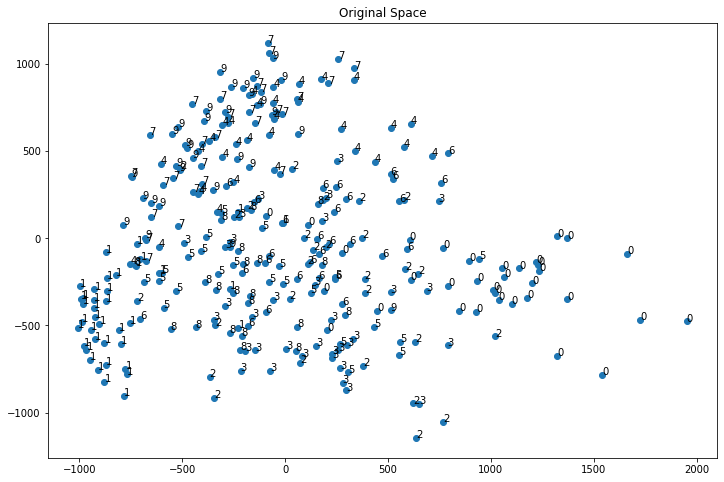

In [27]:
pca = PCA(n_components=2)
print(x_train.shape)
data = np.reshape(x_train,(60000,28*28))
reduced_data = pca.fit_transform(data)

plot_features(reduced_data[:300],y_train[:300],'Original Space')

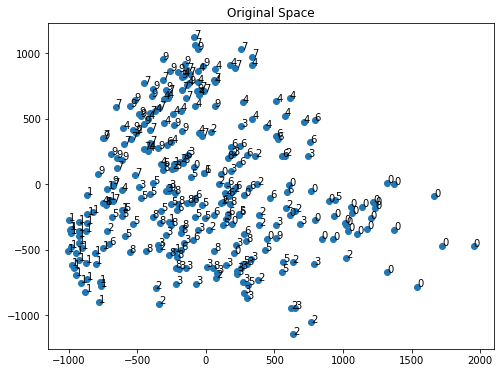

(60000, 28, 28)


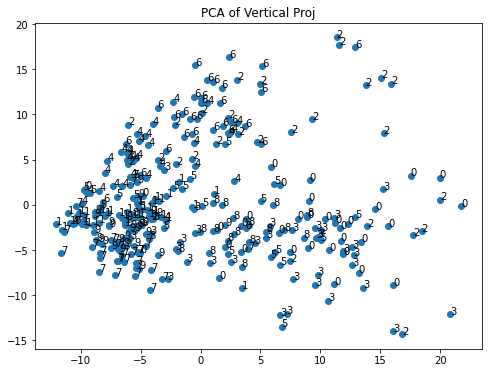

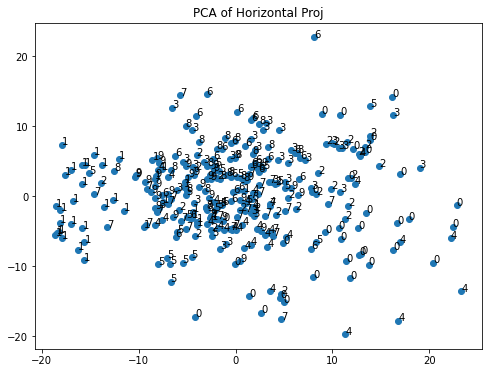

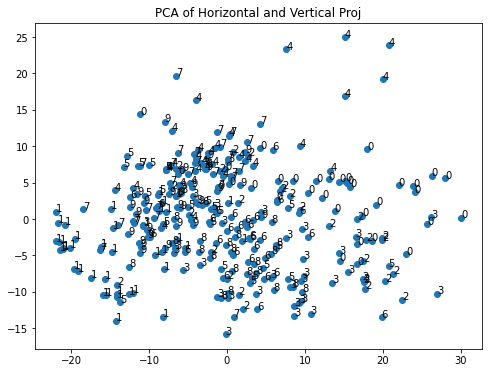

In [38]:
horiz_features = []
vert_features = []
hv_features = []

for img in x_train[:300]:

  #Normalization
  img = cv2.resize(img,(28,28))
  height, width = img.shape
 
  # Sum the value lines 
  vert = np.sum(img, axis=0)
  horiz = np.sum(img, axis=1)
  
  # Normalize 0-255
  vert = vert/255
  horiz = horiz/255
  both = np.concatenate([vert,horiz],axis = 0)
  
  horiz_features.append(vert)
  vert_features.append(horiz)
  hv_features.append(both)


  # create a black image with zeros 
  vert_proj = np.zeros((28,28),dtype=np.uint8)
  horiz_proj = np.zeros((28,28),dtype=np.uint8)
  both_proj = np.zeros((28,56),dtype=np.uint8)
  
  
  # Make the vertical projection histogram
  for idx, value in enumerate(vert):
      cv2.line(vert_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)

  for idx, value in enumerate(horiz):
      cv2.line(horiz_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)
  
  for idx, value in enumerate(both):      
      cv2.line(both_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)


reduced_data = pca.fit_transform(data)

plot_features(reduced_data[:300],y_train[:300],'Original Space',figsize=(8,6))

pca = PCA(n_components=2)
print(x_train.shape)
reduced_data = pca.fit_transform(horiz_features)

reduced_data = PCA(n_components=2).fit_transform(vert_features)
plot_features(reduced_data[:300],y_train[:300],'PCA of Vertical Proj',figsize=(8,6))

reduced_data = PCA(n_components=2).fit_transform(horiz_features)
plot_features(reduced_data[:300],y_train[:300],'PCA of Horizontal Proj',figsize=(8,6))

reduced_data = PCA(n_components=2).fit_transform(hv_features)
plot_features(reduced_data[:300],y_train[:300],'PCA of Horizontal and Vertical Proj',figsize=(8,6))

#Pratice 02
Back to the license plate recognition of Lecture 04. Extract the horizontal and vertical projection and evaluate against your approach